In [2]:

import numpy as np
import torch
from torch.backends import cudnn
cudnn.enabled = True
import voc12.data
import scipy.misc
import importlib
from torch.utils.data import DataLoader
import torchvision
from tool import imutils, pyutils
import argparse
from PIL import Image
import torch.nn.functional as F
import os.path



class Normalize():
    def __init__(self, mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)):

        self.mean = mean
        self.std = std

    def __call__(self, img):
        imgarr = np.asarray(img)
        proc_img = np.empty_like(imgarr, np.float32)

        proc_img[..., 0] = (imgarr[..., 0] / 255. - self.mean[0]) / self.std[0]
        proc_img[..., 1] = (imgarr[..., 1] / 255. - self.mean[1]) / self.std[1]
        proc_img[..., 2] = (imgarr[..., 2] / 255. - self.mean[2]) / self.std[2]

        return proc_img
    
    
    

/mnt/lustre/dingmingyu/software/python3/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/mnt/lustre/dingmingyu/software/python3/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
from pspnet import PSPNet
model = PSPNet(backbone = 'resnet', layers=50, classes=20, zoom_factor=1, pretrained=False, syncbn=False).cuda()
checkpoint = torch.load('exp/drivable/res101_psp_coarse/model/train_epoch_14.pth')

pretrained_dict = {k.replace('module.',''): v for k, v in checkpoint['state_dict'].items()}

dict1 = model.state_dict()
print (dict1.keys(), pretrained_dict.keys())
for item in dict1:
    if item not in pretrained_dict.keys():
        print(item,'nbnmbkjhiuguig~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`')
model.load_state_dict(pretrained_dict, strict=False)

model.eval()
model.cuda()
print(model)
normalize = Normalize()



odict_keys(['layer0.0.weight', 'layer0.1.weight', 'layer0.1.bias', 'layer0.1.running_mean', 'layer0.1.running_var', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.conv3.weight', 'layer1.1.bn3.weight', 'layer1.1.bn3.bias', 'layer1.1.bn3.ru

In [4]:
infer_dataset = voc12.data.VOC12ClsDatasetMSF('voc12/train_aug.txt', voc12_root='../VOC2012',
                                               scales=(1, 0.5, 1.5, 2.0),
                                               inter_transform=torchvision.transforms.Compose(
                                                   [np.asarray,
                                                    normalize,
                                                    imutils.HWC_to_CHW]))

In [5]:
infer_data_loader = DataLoader(infer_dataset, shuffle=False, num_workers=8, pin_memory=True)

In [ ]:
for iter, (img_name, img_list, label) in enumerate(infer_data_loader):
    print(iter,img_name, img_list, label)
    print(list(enumerate(img_list)))
    img_name = img_name[0]; label = label[0]

    img_path = voc12.data.get_img_path(img_name, '../VOC2012')
    orig_img = np.asarray(Image.open(img_path))
    orig_img_size = orig_img.shape[:2]

    with torch.no_grad():
        cam = model.forward_cam(img_list[0].cuda())
        cam = F.upsample(cam, orig_img_size, mode='bilinear', align_corners=False)[0]
        cam = cam.cpu().numpy() * label.clone().view(20, 1, 1).numpy()
    break

In [6]:
iter, (img_name, img_list, label) = enumerate(infer_data_loader).__next__()

In [7]:
img_name,label

(['2007_000032'],
 tensor([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]]))

In [9]:
img_name = img_name[0]; label = label[0]
img_path = voc12.data.get_img_path(img_name, '../VOC2012')
orig_img = np.asarray(Image.open(img_path))
orig_img_size = orig_img.shape[:2]

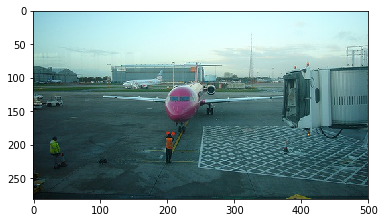

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(orig_img)

In [12]:
with torch.no_grad():
    cam = model.forward_cam(img_list[0].cuda())
    cam1 = F.upsample(cam, orig_img_size, mode='bilinear', align_corners=False)[0]
    cam2 = cam1.cpu().numpy() * label.clone().view(20, 1, 1).numpy()

In [16]:
cam

tensor([[[[   0.0000,    4.2702,    0.0000,  ...,    0.0000,
              0.0000,    0.0000],
          [   3.6813,    5.9725,    7.4005,  ...,    0.0000,
              0.0000,    0.0000],
          [   0.0000,   10.0352,    0.0000,  ...,    0.0000,
              0.0000,    0.0000],
          ...,
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,
              0.0000,    0.0000],
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,
              0.0000,    0.0000],
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,
              0.0000,    0.0000]],

         [[   0.0000,    0.0000,    0.0000,  ...,    0.3662,
              0.2647,    0.0000],
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,
              0.0000,    0.0000],
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,
              0.0000,    0.0000],
          ...,
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,
              0.0000,    0.0000],
          [   0.00

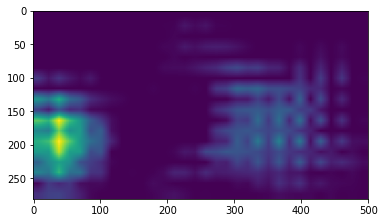

In [23]:
plt.imshow(cam1.cpu().numpy()[14])

In [21]:
cam1

tensor([[[   0.0000,    0.0000,    0.0000,  ...,    0.0000,
             0.0000,    0.0000],
         [   0.0000,    0.0000,    0.0000,  ...,    0.0000,
             0.0000,    0.0000],
         [   0.0000,    0.0000,    0.0000,  ...,    0.0000,
             0.0000,    0.0000],
         ...,
         [   0.0000,    0.0000,    0.0000,  ...,    0.0000,
             0.0000,    0.0000],
         [   0.0000,    0.0000,    0.0000,  ...,    0.0000,
             0.0000,    0.0000],
         [   0.0000,    0.0000,    0.0000,  ...,    0.0000,
             0.0000,    0.0000]],

        [[   0.0000,    0.0000,    0.0000,  ...,    0.0000,
             0.0000,    0.0000],
         [   0.0000,    0.0000,    0.0000,  ...,    0.0000,
             0.0000,    0.0000],
         [   0.0000,    0.0000,    0.0000,  ...,    0.0000,
             0.0000,    0.0000],
         ...,
         [   0.0000,    0.0000,    0.0000,  ...,    0.0000,
             0.0000,    0.0000],
         [   0.0000,    0.0000,    0.000

In [24]:
cam2

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

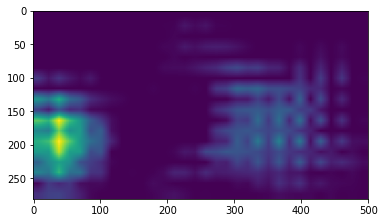

In [25]:
plt.imshow(cam2[14])

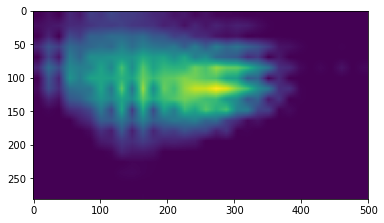

In [26]:
plt.imshow(cam2[0])

In [33]:
cam2[14]

array([[ 0.48267657,  0.48267657,  0.48267657, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.48267657,  0.48267657,  0.48267657, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.48267657,  0.48267657,  0.48267657, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [20.746809  , 20.746809  , 20.746809  , ...,  0.        ,
         0.        ,  0.        ],
       [20.746809  , 20.746809  , 20.746809  , ...,  0.        ,
         0.        ,  0.        ],
       [20.746809  , 20.746809  , 20.746809  , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [38]:
sum_cam = np.sum([cam2,cam2], axis=0)

In [40]:
sum_cam.shape

(20, 281, 500)

In [41]:
norm_cam = sum_cam / (np.max(sum_cam, (1, 2), keepdims=True) + 1e-5)

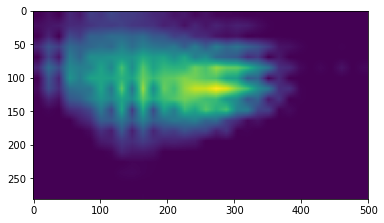

In [47]:
plt.imshow(norm_cam[0])

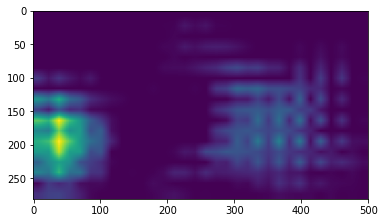

In [44]:
plt.imshow(norm_cam[14])

In [53]:
norm_cam[14].max()

1.0

In [58]:
bg_score = [np.ones_like(norm_cam[0])*0.2]

In [59]:
bg_score

[array([[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        ...,
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]], dtype=float32)]

In [60]:
pred = np.argmax(np.concatenate((bg_score, norm_cam)), 0)

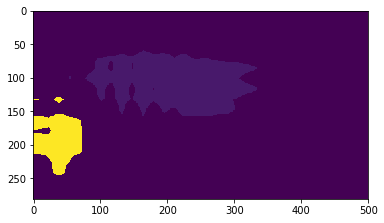

In [61]:
plt.imshow(pred)

In [62]:
cam_dict = {}
for i in range(20):
    if label[i] > 1e-5:
        cam_dict[i] = norm_cam[i]

In [63]:
cam_dict

{0: array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 14: array([[0.0033375 , 0.0033375 , 0.0033375 , ..., 0.        , 0.        ,
         0.        ],
        [0.0033375 , 0.0033375 , 0.0033375 , ..., 0.        , 0.        ,
         0.        ],
        [0.0033375 , 0.0033375 , 0.0033375 , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.14345516, 0.14345516, 0.14345516, ..., 0.        , 0.        ,
         0.        ],
        [0.14345516, 0.14345516, 0.14345516, ..., 0.        , 0.        ,
         0.        ],
        [0.14345516, 0.14345516, 0.14345516, ..., 0.        , 0.        ,
         0.        ]], dtype=float32)}

In [ ]:
v = np.array(list(cam_dict.values()))
bg_score = np.power(1 - np.max(v, axis=0, keepdims=True), alpha)
bgcam_score = np.concatenate((bg_score, v), axis=0)
crf_score = imutils.crf_inference(orig_img, bgcam_score, labels=bgcam_score.shape[0])

n_crf_al = dict()

n_crf_al[0] = crf_score[0]
for i, key in enumerate(cam_dict.keys()):
    n_crf_al[key+1] = crf_score[i+1]

return n_crf_al

In [64]:
v = np.array(list(cam_dict.values()))

In [71]:
v.shape

(2, 281, 500)

In [80]:
bg_score = np.power(1 - np.max(v, axis=0, keepdims=True), 32)

In [81]:
bgcam_score = np.concatenate((bg_score, v), axis=0)

In [82]:
crf_score = imutils.crf_inference(orig_img, bgcam_score, labels=bgcam_score.shape[0])

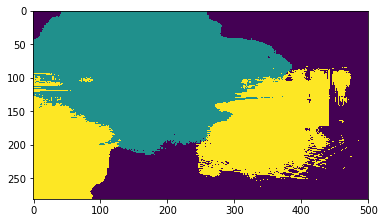

In [83]:
plt.imshow(np.argmax(crf_score,0))

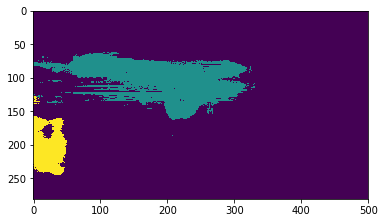

In [79]:
plt.imshow(np.argmax(crf_score,0))